# Traffic Analysis

This notebook introduces most of the traffic analysis conducted as part of the project.

The analysis covers a variety of research questions as described below.

The analysis is based on the representation of the traffic data as described in "Basic Processing.ipynb".

#### Contents
- [The fundamental traffic diagram](#The-fundamental-traffic-diagram): analysis of rush hours and of the relations between traffic speed, density and flux.
- [Temporal patterns within videos](#Temporal-patterns-within-videos): fluctuations of speed within a sample of videos look quite arbitrary and probably negligible compared to the differences between videos.
- [Spatial analysis](#Spatial-analysis): the higher traffic speed (and lower density) in the left lanes is very clear. The speed differences are more significant as the density decreases closer to free-flow.
- [Lane transitions](#Lane-transitions): lane-transitions usually occur in the right lanes on low speeds, although fast vehicles sometimes move left on lefter lanes as well. Left-transitions are usually followed by speed increase of a 4 km/h on average. Transitions externalities could not be studied reliably from the data.
- [Predicting models](#Predicting-models): A memoryless linear model to predict speed-change of vehicles on a certain lane according to the speeds on the adjacent lanes can explain 18% (out-of-sample) of the variance of the speed changes. According to the model, on average, more than 50% of the speed-differences between adjacent lanes diminish within 50 meters.
- [Extreme events](#Extreme-events): fastest & slowest vehicles, most & least dense frames, and a congestion on the wrong side of the road.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn import linear_model
from sklearn.model_selection import cross_validate

import BasicProcessor as bp

In [3]:
if '../Tracker' not in sys.path: sys.path.append('../Tracker')
import Tracker as t

In [4]:
mpl.rcParams.update({'font.size': 15})

## Load data

In [5]:
df, sf = bp.load_data_summary()
df.shape, sf.shape

((82091, 89), (186746, 104))

In [6]:
vf = pd.read_csv(r'../Photographer/videos_metadata.csv', index_col=0)
print(vf.shape)
vf.head()

(81, 6)


,video,size_mb,len_minutes,date,time,weekday
20190520_105429.mp4,20190520_105429.mp4,115.474790,7.231111,20190520,10.908056,2
20190520_112342.mp4,20190520_112342.mp4,522.146511,32.755556,20190520,11.395000,2
20190520_141707.mp4,20190520_141707.mp4,129.201198,8.102222,20190520,14.285278,2
20190520_151643.mp4,20190520_151643.mp4,134.681172,8.435556,20190520,15.278611,2
20190520_171559.mp4,20190520_171559.mp4,166.763672,10.453333,20190520,17.266389,2


In [7]:
nf = bp.detections_count()
nf.head()

,video,n_frames,n_detections,detections_per_frame,n_detections_sd
20190520_105429,20190520_105429,1627,28986,17.8156,8.160223
20190520_112342,20190520_112342,7370,87822,11.9161,2.973200
20190520_141707,20190520_141707,1823,41040,22.5123,5.383049
20190520_151643,20190520_151643,1898,61264,32.2782,4.186581
20190520_171559,20190520_171559,2352,37159,15.7989,3.676079


## The fundamental traffic diagram

- The **distributions of traffic speed & density look reasonable**, and in particular have larger variance between videos than within videos.
- Density trends over days and hours are very similar to what could be expected (**rush hours around 16-17 on buisiness days, 12-13 on Fridays and 19-20 on Saturdays**).
    - No heavy traffic was observed in the morning, probably either because the road interval is not a major one for entering Tel-Aviv (it's beyond *Hashalom* interchange) or because the earliest videos are after 8:30am.
- In heavy traffic densities, it looks like the **gap between detected vehicles and fully-tracked vehicles paths can reach 30%** (due to failures to track the full path), which accordingly may insert noise to other calculations.
- The ***Fundamental Traffic Diagram*** - i.e. the relations between speed, density and flux - looks very similar to the theoretic one drawn by Ammoser et al. In particular:
    - The speed is quite linear in density.
    - The flux-vs-density diagram shows clear separation between free-flow traffic and congestion.
    - **The maximum-flux speed is around 60 km/h**, which is slightly smaller than the typical *critical velocity* of Ammoser et al.
    - There is a single major outlier to the flux-vs-density diagram from 25/5/19, where there was a single dense lane on the right. The flux was small in both the right (very slow) lane and the left (quite empty) lanes, whereas the average density was neither small nor large, deviating from the diagram. This video looks quite fascinating and its dynamics can be further studied in future.

In [8]:
# Speed per video - averaged over frames (not cars) - giving larger weight to (slow) cars with many frames...
n_per_line = bp.get_cols(sf, 'n', spatial=True, return_data=True).iloc[:,1:]
v_per_line = bp.get_cols(sf, 'v', spatial=True, return_data=True)

n_per_line.columns = np.arange(n_per_line.shape[1])
v_per_line.columns = np.arange(n_per_line.shape[1])

v_per_frame = (n_per_line*v_per_line).sum(axis=1, skipna=True) / (n_per_line).sum(axis=1, skipna=True)

v_per_video = 3.6*pd.DataFrame({'video':sf.video, 'v':v_per_frame}).groupby('video')['v'].apply(np.mean)

n_lanes = 5
road_len = df.max_x.max()-0 # (min_x has some weird outlier)

avg_speeds = 3.6*df.groupby('video')['abs_v'].apply(np.mean)
detections_per_10m = nf.detections_per_frame / (n_lanes*road_len/10)
flux = df.groupby('video')['car'].apply(len) / vf.len_minutes

tracked_per_frame = sf[bp.get_cols(sf, 'n', spatial=True)[1:]].sum(axis=1, skipna=True)
tracked_per_10m = tracked_per_frame / (n_lanes*(bp.X_REF.max()-bp.X_REF.min())/10)
sf['tracked_per_10m'] = tracked_per_10m
tracked_per_10m = sf.groupby('video')['tracked_per_10m'].apply(np.mean)

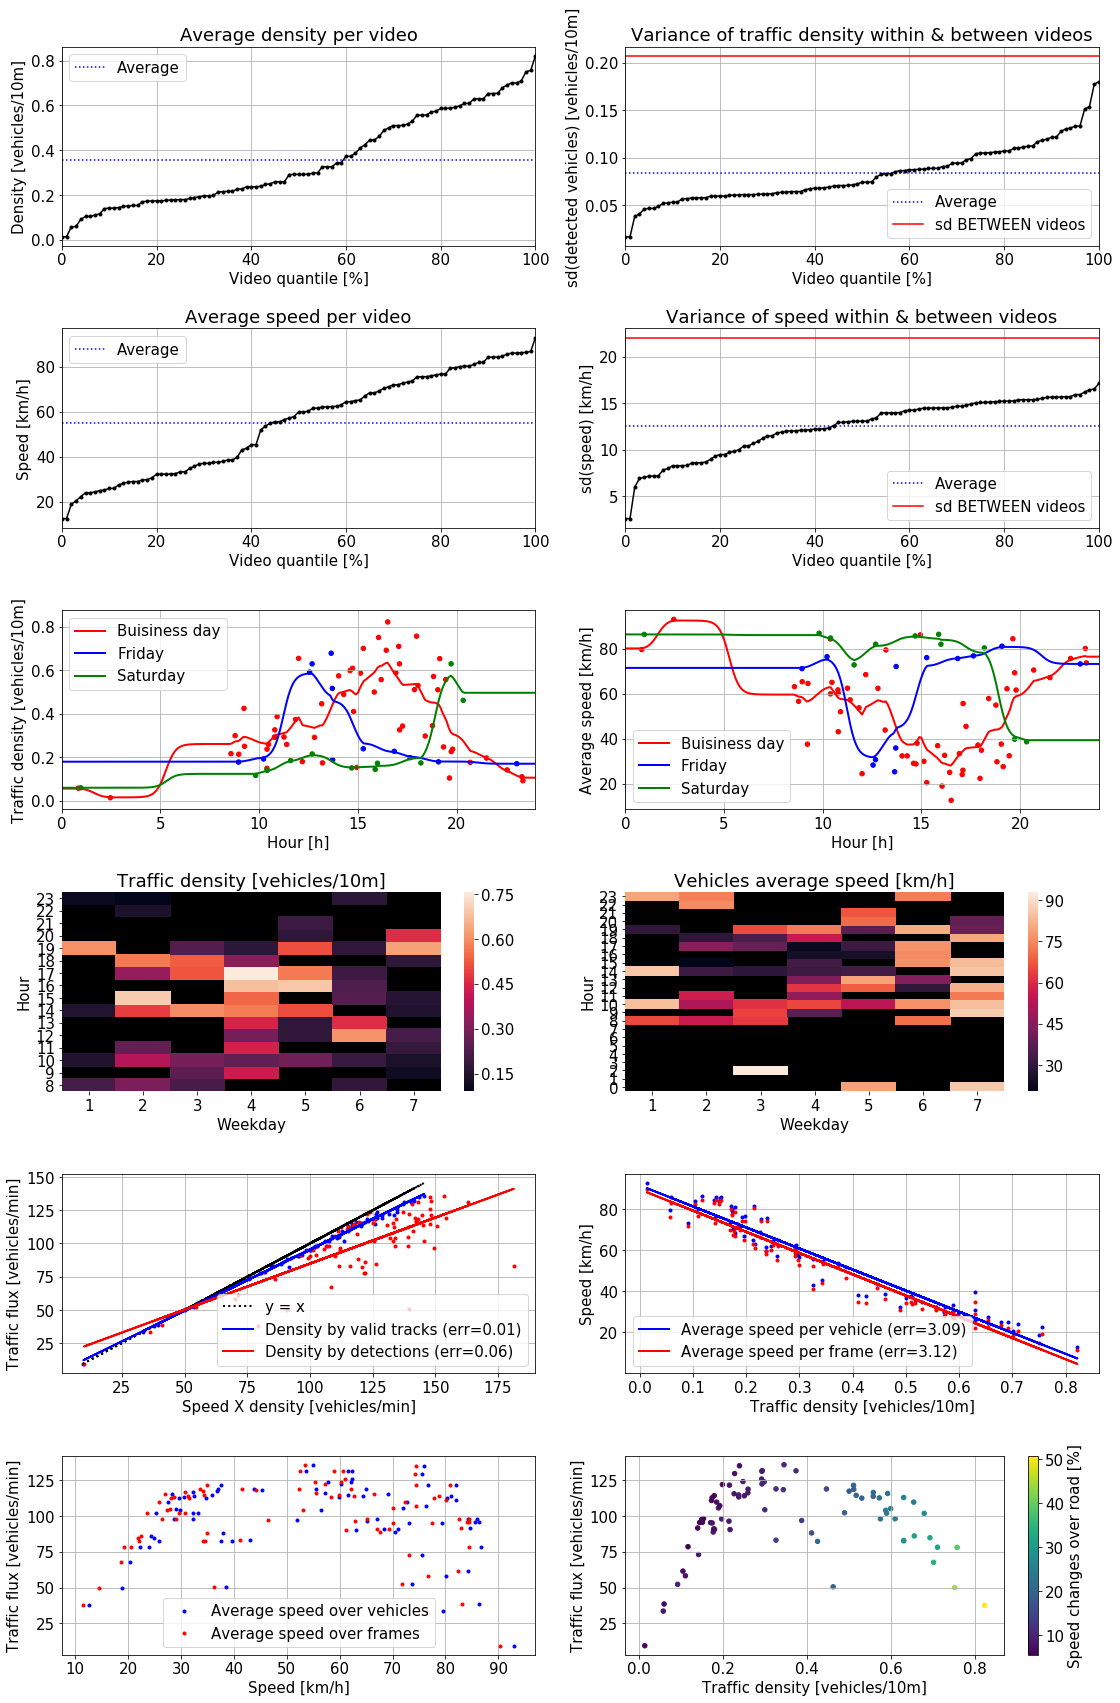

In [9]:
_, axs = plt.subplots(6,2, figsize=(16,24))

# vehicles per frame
ax = axs[0,0]
t.qplot(detections_per_10m, xlab='Video', ylab='Density [vehicles/10m]', ax=ax)
ax.set_title('Average density per video')

ax = axs[0,1]
t.qplot(nf.n_detections_sd / (n_lanes*road_len/10), xlab='Video', ylab='sd(detected vehicles) [vehicles/10m]', ax=ax)
ax.axhline(detections_per_10m.std(),
           color='r', label='sd BETWEEN videos')
ax.set_title('Variance of traffic density within & between videos')
ax.legend()

# speed distribution
ax = axs[1,0]
t.qplot(avg_speeds, xlab='Video', ylab='Speed [km/h]', ax=ax)
ax.set_title('Average speed per video')

ax = axs[1,1]
t.qplot(3.6*df.groupby('video')['abs_v'].apply(np.std), xlab='Video', ylab='sd(speed) [km/h]', ax=ax)
ax.axhline(avg_speeds.std(), color='r', label='sd BETWEEN videos')
ax.set_title('Variance of speed within & between videos')
ax.legend()

# info vs time by day
ax = axs[2,0]
ax.scatter(vf.time, detections_per_10m, s=20, c=['red' if day<=5 else 'blue' if day==6 else 'green' for day in vf.weekday])
hours = np.arange(0,24.01,0.1)
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values<=5].time, detections_per_10m[vf.weekday.values<=5], 0.5),
        'r-', linewidth=2, label='Buisiness day')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==6].time, detections_per_10m[vf.weekday.values==6], 0.5),
        'b-', linewidth=2, label='Friday')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==7].time, detections_per_10m[vf.weekday.values==7], 0.5),
        'g-', linewidth=2, label='Saturday')
ax.set_xlim((0,24))
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Traffic density [vehicles/10m]')
ax.grid()
ax.legend()

# # (before vs. after school-vacation-beginning - not enough data)
# ax = axs[2,0]
# bd = vf.weekday.values <= 5
# ax.scatter(vf[bd].time, detections_per_10m[bd], s=20, c=['red' if date<20190620 else 'blue' if date<20190701 else 'green'
#                                                  for date in vf[bd].date])
# hours = np.arange(0,24.01,0.1)
# ax.plot(hours, bp.rolling(hours, vf[bd & (vf.date<20190620)].time, detections_per_10m[(bd & (vf.date<20190620)).values], 0.5),
#         'r-', linewidth=2, label='Before 20/6')
# ax.plot(hours, bp.rolling(hours, vf[bd & (vf.date>=20190620) & (vf.date<20190701)].time,
#                           detections_per_10m[(bd & (vf.date>=20190620) & (vf.date<20190701)).values], 0.5),
#         'b-', linewidth=2, label='20/6-30/6')
# ax.plot(hours, bp.rolling(
#         hours, vf[bd & (vf.date>=20190701)].time, detections_per_10m[(bd & (vf.date>=20190701)).values], 0.5),
#         'g-', linewidth=2, label='From 1/7')
# ax.set_xlim((0,24))
# ax.set_title('Buisiness days only')
# ax.set_xlabel('Hour [h]')
# ax.set_ylabel('Traffic density [vehicles/10m]')
# ax.grid()
# ax.legend()

ax = axs[2,1]
ax.scatter(vf.time, avg_speeds, s=20, c=['red' if day<=5 else 'blue' if day==6 else 'green' for day in vf.weekday])
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values<=5].time, avg_speeds[vf.weekday.values<=5], 0.5),
        'r-', linewidth=2, label='Buisiness day')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==6].time, avg_speeds[vf.weekday.values==6], 0.5),
        'b-', linewidth=2, label='Friday')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==7].time, avg_speeds[vf.weekday.values==7], 0.5),
        'g-', linewidth=2, label='Saturday')
ax.set_xlim((0,24))
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Average speed [km/h]')
ax.grid()
ax.legend()

# info per time & day
ax = axs[3,0]
mean_or_nan = lambda x: np.mean(x) if len(x)>0 else np.nan
dets_hm = np.array([[mean_or_nan(detections_per_10m.values[np.logical_and(vf.weekday==day,np.floor(vf.time)==hour)])
                     for day in np.arange(1,8)] for hour in np.arange(8,24)])
sns.heatmap(dets_hm, xticklabels=np.arange(1,8,dtype=int), yticklabels=np.arange(8,24,dtype=int), ax=ax)
ax.invert_yaxis()
ax.set_facecolor("black")
ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_title('Traffic density [vehicles/10m]')

ax = axs[3,1]
speed_hm = np.array([[mean_or_nan(avg_speeds.values[np.logical_and(vf.weekday==day,np.floor(vf.time)==hour)])
                     for day in np.arange(1,8)] for hour in np.arange(24)])
sns.heatmap(speed_hm, xticklabels=np.arange(1,8,dtype=int), yticklabels=np.arange(24,dtype=int), ax=ax)
ax.invert_yaxis()
ax.set_facecolor("black")
ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_title('Vehicles average speed [km/h]')

# the fundamental traffic diagram
ax = axs[4,0]
A = (1000/10*n_lanes) / 60 # km/10m*lanes / hour
fx1 = A*tracked_per_10m.astype(float).values*v_per_video.values
fx2 = A*detections_per_10m.astype(float).values*v_per_video.values
ax.plot(fx1, flux, 'b.')
ax.plot(fx2, flux, 'r.')
ax.plot(fx1, fx1, 'k:', linewidth=2, label=f'y = x')
slope, intercept, _, _, std_err = stats.linregress(fx1, flux)
preds = intercept + slope * fx1
ax.plot(fx1, preds, 'b-', linewidth=2, label=f'Density by valid tracks (err={std_err:.2f})')
slope, intercept, _, _, std_err = stats.linregress(fx2, flux)
preds = intercept + slope * fx2
ax.plot(fx2, preds, 'r-', linewidth=2, label=f'Density by detections (err={std_err:.2f})')
ax.set_xlabel('Speed X density [vehicles/min]')
ax.set_ylabel('Traffic flux [vehicles/min]')
ax.grid()
ax.legend()

ax = axs[4,1]
# note: calculating average speed per vehicle vs. per frame is very similar to mean vs. harmonic-mean
ax.plot(detections_per_10m, avg_speeds, 'b.')
ax.plot(detections_per_10m, v_per_video, 'r.')
slope, intercept, _, _, std_err = stats.linregress(detections_per_10m.astype(float), avg_speeds)
preds = intercept + slope * detections_per_10m
ax.plot(detections_per_10m, preds, 'b-', linewidth=2, label=f'Average speed per vehicle (err={std_err:.2f})')
slope, intercept, _, _, std_err = stats.linregress(detections_per_10m.astype(float), v_per_video)
preds = intercept + slope * detections_per_10m
ax.plot(detections_per_10m, preds, 'r-', linewidth=2, label=f'Average speed per frame (err={std_err:.2f})')
ax.set_xlabel('Traffic density [vehicles/10m]')
ax.set_ylabel('Speed [km/h]')
ax.grid()
ax.legend()

ax = axs[5,0]
ax.plot(avg_speeds, flux, 'b.', label='Average speed over vehicles')
ax.plot(v_per_video, flux, 'r.', label='Average speed over frames')
ax.set_xlabel('Speed [km/h]')
ax.set_ylabel('Traffic flux [vehicles/min]')
ax.grid()
ax.legend()

ax = axs[5,1]
avg_v_std = 100*np.array([np.mean(df.v_sd[df.video==v]/df.v[df.video==v]) for v in vf.video])
sc = ax.scatter(detections_per_10m, flux, s=20, c=avg_v_std, cmap='viridis')
cbar = plt.colorbar(sc, ax=ax)
cbar.ax.set_ylabel(f'Speed changes over road [%]')
# ax.plot(detections_per_10m, flux, 'b.')
ax.set_xlabel('Traffic density [vehicles/10m]')
ax.set_ylabel('Traffic flux [vehicles/min]')
ax.grid()
# The main outlier in flux vs. density is the 20190525_202019 in which
# there was a slow queue in the right (large density) along with smooth motion in the left (large flux).

plt.tight_layout()

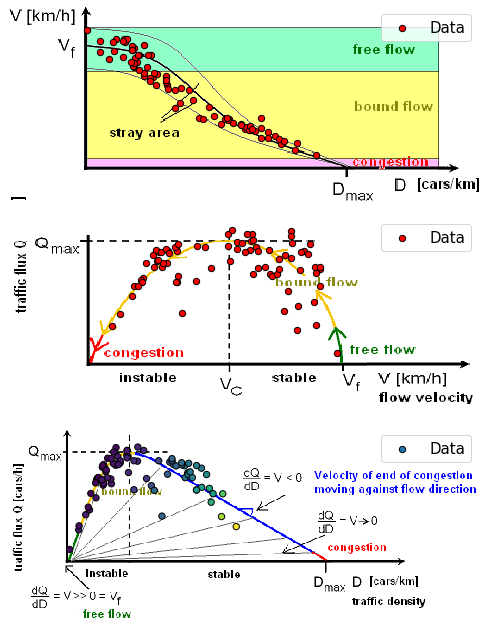

In [96]:
_, axs = plt.subplots(3,1, figsize=(7,9))

ax = axs[0]
ax.imshow(plt.imread("../Outputs/Analysis/Videos buckets/ref speed vs density.png"),
          extent=[-0.27, 1.4, -17, 105], aspect='auto')
ax.scatter(detections_per_10m, v_per_video, s=40, c='r', edgecolors='k', label='Data')
ax.legend()
ax.axis('off')

ax = axs[1]
ax.imshow(plt.imread("../Outputs/Analysis/Videos buckets/References/ref flux vs speed.png"),
          extent=[-25, 140, -50, 130], aspect='auto')
ax.scatter(v_per_video, flux, s=40, c='r', edgecolors='k', label='Data')
ax.legend()
ax.axis('off')

ax = axs[2]
ax.imshow(plt.imread("../Outputs/Analysis/Videos buckets/References/ref flux vs density.png"),
          extent=[-0.29, 2, -80, 160], aspect='auto')
# x, y = zip(*sorted(zip(detections_per_10m, flux)))
# ax.plot(x, bp.rolling(x, x, y, 0.03), 'r-', linewidth=1)
# avg_v_std = 100*np.array([np.mean(df.v_sd[df.video==v]/df.v[df.video==v]) for v in vf.video])
# ax.scatter(detections_per_10m, flux, s=40, c='r', edgecolors='k', label='Data')
sc = ax.scatter(detections_per_10m, flux, s=40, c=avg_v_std, cmap='viridis', edgecolors='k', label='Data')
# cbar = plt.colorbar(sc, ax=ax)
# cbar.ax.set_ylabel(f'Speed changes over road [%]')
ax.legend()
ax.axis('off')

plt.tight_layout()
plt.savefig('../Outputs/Analysis/Videos buckets/References/Fundamental diagram vs reference.png')

## Temporal patterns within videos

No interesting patterns.
The noise in the "almost empty" video is probably caused by the small number of vehicles per time-window.

In [501]:
titles = ('Max flux', 'Almost empty', 'Right lane congestion', 'Slight congestion', 'Heavy congestion')
videos = ('20190612_184651', '20190604_022732', '20190525_202019', '20190607_124056', '20190703_163050_slipping_protest.2')

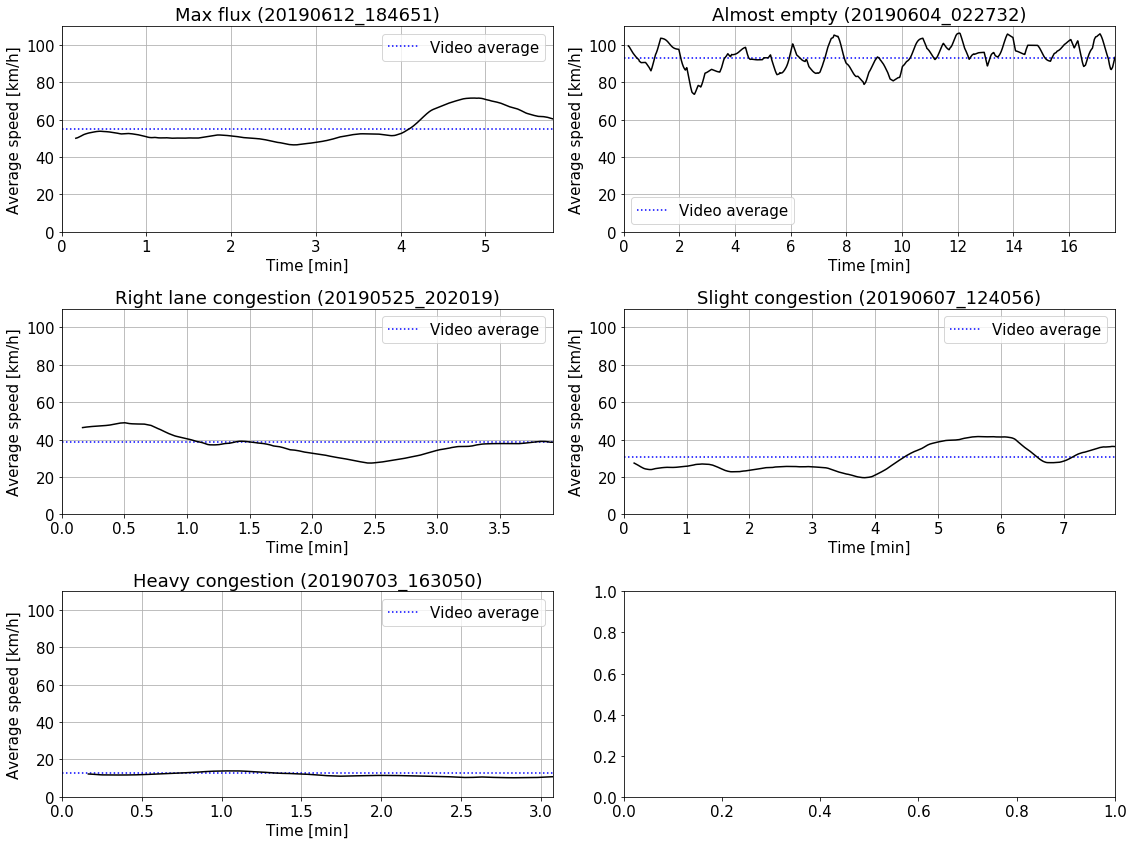

In [508]:
_, axs = plt.subplots(3,2, figsize=(16,12))

for i, (video,tit) in tqdm_notebook(enumerate(zip(videos,titles)), total=len(videos)):
    dfv = df[df.video==f'{video:s}.mp4']
    times = np.arange(10, dfv.t0.max()-10, 1/(30/8))
    decay = 10 # 1/e factor every "decay" seconds
    ws = [np.exp(-np.abs(dfv.t0-t)/decay) for t in times]
    rolling_speed = [3.6*np.sum(w*dfv.v)/np.sum(w) for w in ws]

    ax = axs[i//2, i%2]
    ax.axhline(3.6*dfv.abs_v.mean(), color='blue', linestyle=':', label='Video average')
    ax.plot(times/60, rolling_speed, 'k')
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Average speed [km/h]')
    ax.set_title(f'{tit:s} ({video[:15]:s})')
    ax.set_xlim((0,times[-1]/60))
    ax.set_ylim((0,110))
    ax.legend()
    ax.grid()
    
plt.tight_layout()

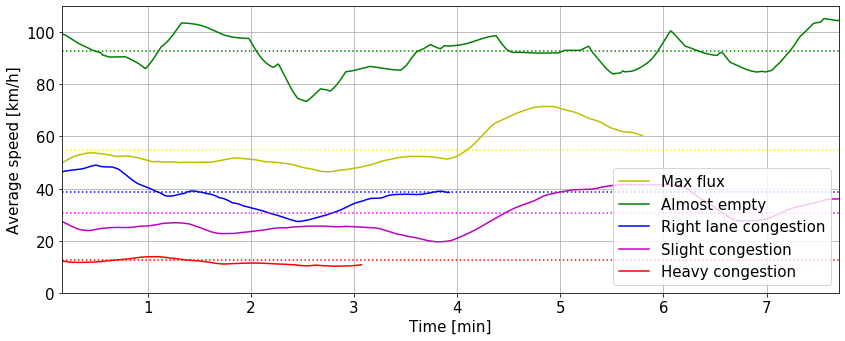

In [519]:
_, axs = plt.subplots(1,1, figsize=(12,5))
ax = axs
colors = ('yellow','green','blue','magenta','red')
decay = 10 # 1/e factor every "decay" seconds

for i, (video,tit) in tqdm_notebook(enumerate(zip(videos,titles)), total=len(videos)):
    dfv = df[df.video==f'{video:s}.mp4']
    times = np.arange(10, dfv.t0.max()-10, 1/(30/8))
    ws = [np.exp(-np.abs(dfv.t0-t)/decay) for t in times]
    rolling_speed = [3.6*np.sum(w*dfv.v)/np.sum(w) for w in ws]

    ax.axhline(3.6*dfv.abs_v.mean(), color=colors[i], linestyle=':')
    ax.plot(times/60, rolling_speed, colors[i][0], label=tit)
    ax.set_xlabel('Time [min]')
    ax.set_ylabel('Average speed [km/h]')

ax.set_xlim((10/60,7.7))
ax.set_ylim((0,110))
ax.legend(loc='lower right')
ax.grid()
    
plt.tight_layout()

## Spatial analysis

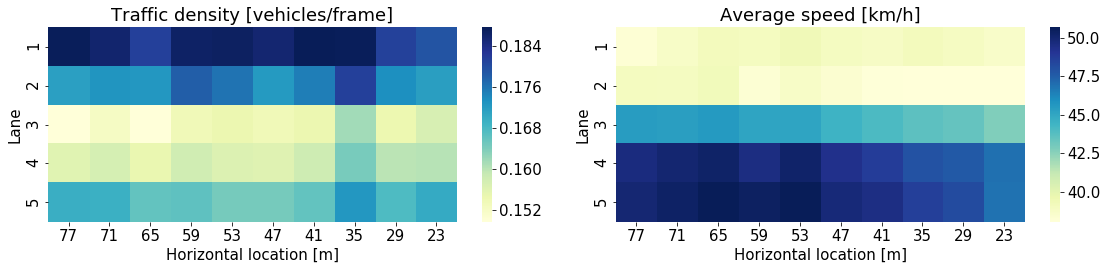

In [115]:
_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
dense_hm = np.array([[sf[f'n_x{x1:d}to{x2:d}_l{l+1:d}'].mean()
                      for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:])] for l in range(5)])
sns.heatmap(dense_hm, xticklabels=np.array((bp.X_REF[:-1]+bp.X_REF[1:])/2,dtype=int),
            yticklabels=np.arange(1,6,dtype=int), ax=ax, cmap="YlGnBu")
ax.invert_xaxis()
ax.set_facecolor("black")
ax.set_xlabel('Horizontal location [m]')
ax.set_ylabel('Lane')
ax.set_title('Traffic density [vehicles/frame]')

ax = axs[1]
speed_hm = 3.6*np.array([[sf[f'v_x{x1:d}to{x2:d}_l{l+1:d}'].mean(skipna=True)
                          for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:])] for l in range(5)])
sns.heatmap(speed_hm, xticklabels=np.array((bp.X_REF[:-1]+bp.X_REF[1:])/2,dtype=int),
            yticklabels=np.arange(1,6,dtype=int), ax=ax, cmap="YlGnBu")
ax.invert_xaxis()
ax.set_facecolor("black")
ax.set_xlabel('Horizontal location [m]')
ax.set_ylabel('Lane')
ax.set_title('Average speed [km/h]')

plt.tight_layout()

In [458]:
density_thresholds = np.quantile(detections_per_10m, np.arange(0,1.01,0.2))
density_group = np.zeros_like(detections_per_10m)
for thresh in density_thresholds[:-1]:
    density_group[detections_per_10m>=thresh] += 1
density_group = pd.Series(density_group, index = [v[:-4] for v in vf.video])

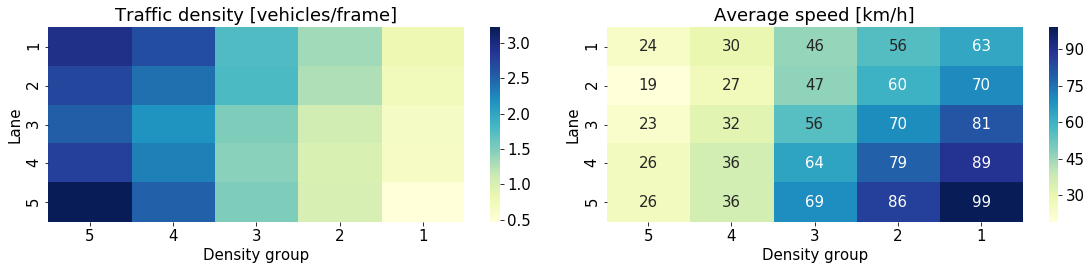

In [474]:
_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
dense_hm = np.array([[[sf.loc[(density_group[sf.video]==dg).values,f'n_x{x1:d}to{x2:d}_l{l+1:d}'].mean()
                       for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:])] for dg in range(1,6)] for l in range(5)]).sum(axis=2)
sns.heatmap(dense_hm, xticklabels=np.arange(1,6,dtype=int),
            yticklabels=np.arange(1,6,dtype=int), ax=ax, cmap="YlGnBu")
ax.invert_xaxis()
ax.set_facecolor("black")
ax.set_xlabel('Density group')
ax.set_ylabel('Lane')
ax.set_title('Traffic density [vehicles/frame]')

ax = axs[1]
speed_hm = 3.6*np.array([[[sf.loc[(density_group[sf.video]==dg).values,f'v_x{x1:d}to{x2:d}_l{l+1:d}'].mean(skipna=True)
                          for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:])] for dg in range(1,6)] for l in range(5)]).mean(axis=2)
sns.heatmap(speed_hm, xticklabels=np.arange(1,6,dtype=int),
            yticklabels=np.arange(1,6,dtype=int), ax=ax, cmap="YlGnBu", annot=True, fmt='.0f')
ax.invert_xaxis()
ax.set_facecolor("black")
ax.set_xlabel('Density group')
ax.set_ylabel('Lane')
ax.set_title('Average speed [km/h]')

plt.tight_layout()

## Lane transitions

#### Load lane-transitions data

In [215]:
trans = pd.read_csv('../tracker/track_data/lane_transitions.csv')
print(trans.shape)
trans.head()

(21601, 7)


,video,car,x1,x2,lane_1,lane_2,transition
0,20190520_105429.mp4,36,20,26,1.0,2.0,1.0
1,20190520_105429.mp4,36,44,50,2.0,3.0,1.0
2,20190520_105429.mp4,46,20,26,2.0,1.0,-1.0
3,20190520_105429.mp4,46,26,32,1.0,2.0,1.0
4,20190520_105429.mp4,46,38,44,2.0,1.0,-1.0


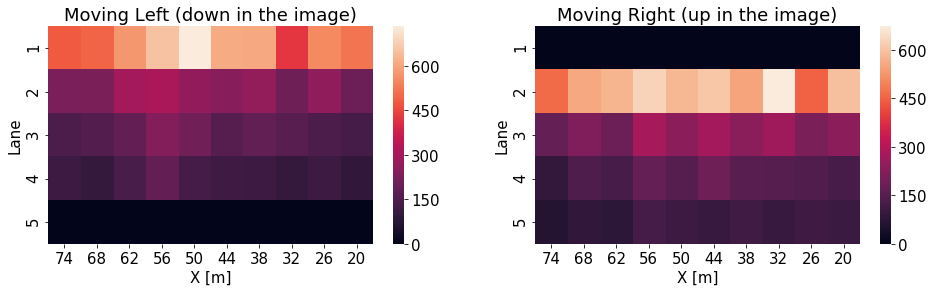

In [121]:
bp.show_transitions(trans)

#### Count lane-transitions by lane & speed

Most transitions are either of slow vehicles in the right, or of fast vehicles in the left.

In [137]:
trans['speed'] = [df.loc[(df.video==v) & (df.car==c),'abs_v'].values[0]
                  for v,c in tqdm_notebook(zip(trans.video,trans.car),total=len(trans))]

In [171]:
def transitions_per_speed(transitions, v_thresh=(0,30,50,65,80,150), K=5, axs=None):
    lane_transitions_d = transitions[transitions.transition > 0]
    lane_transitions_u = transitions[transitions.transition < 0]
    
    trans_per_cell_d = np.zeros((K, len(v_thresh)-1))
    trans_per_cell_u = np.zeros((K, len(v_thresh)-1))
    for i, l in enumerate(range(1, 6)):
        for j, (v1,v2) in enumerate(zip(v_thresh[:-1],v_thresh[1:])):
            trans_per_cell_d[i, j] = \
            ((3.6*lane_transitions_d.speed>=v1) & (3.6*lane_transitions_d.speed<v2) & (lane_transitions_d.lane_1 == l)).sum()
            trans_per_cell_u[i, j] = \
            ((3.6*lane_transitions_u.speed>=v1) & (3.6*lane_transitions_u.speed<v2) & (lane_transitions_u.lane_1 == l)).sum()

    if axs is None:
        _, axs = plt.subplots(1, 2, figsize=(16, 4))

    ax = axs[0]
    sns.heatmap(trans_per_cell_d,
                xticklabels=[f'{v2:d}-{v1:d}' for v1,v2 in zip(v_thresh[:-1],v_thresh[1:])],
                yticklabels=1 + np.arange(5), ax=ax)
    ax.invert_xaxis()
    ax.set_title('Moving Left (down in the image)')
    ax.set_xlabel('Speed [km/h]')
    ax.set_ylabel('Lane')

    ax = axs[1]
    sns.heatmap(trans_per_cell_u,
                xticklabels=[f'{v2:d}-{v1:d}' for v1,v2 in zip(v_thresh[:-1],v_thresh[1:])],
                yticklabels=1 + np.arange(5), ax=ax)
    ax.invert_xaxis()
    ax.set_title('Moving Right (up in the image)')
    ax.set_xlabel('Speed [km/h]')
    ax.set_ylabel('Lane')

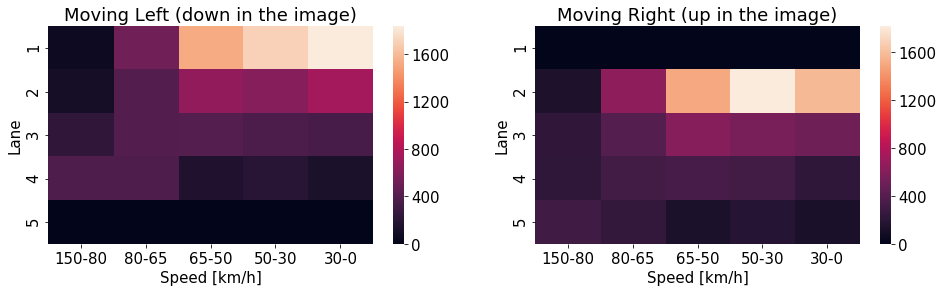

In [172]:
transitions_per_speed(trans)

In [154]:
trans['video_speed'] = [v_per_video[v[:-4]] for v in trans.video]

In [173]:
def transitions_per_rel_speed(transitions, v_thresh=(0,0.8,1.2,3.5), K=5, axs=None):
    lane_transitions_d = transitions[transitions.transition > 0]
    lane_transitions_u = transitions[transitions.transition < 0]
    
    trans_per_cell_d = np.zeros((K, len(v_thresh)-1))
    trans_per_cell_u = np.zeros((K, len(v_thresh)-1))
    for i, l in enumerate(range(1, 6)):
        for j, (v1,v2) in enumerate(zip(v_thresh[:-1],v_thresh[1:])):
            trans_per_cell_d[i, j] = \
            ((3.6*lane_transitions_d.speed/lane_transitions_d.video_speed>=v1) & \
             (3.6*lane_transitions_d.speed/lane_transitions_d.video_speed<v2) & (lane_transitions_d.lane_1 == l)).sum()
            trans_per_cell_u[i, j] = \
            ((3.6*lane_transitions_u.speed/lane_transitions_u.video_speed>=v1) & \
             (3.6*lane_transitions_u.speed/lane_transitions_u.video_speed<v2) & (lane_transitions_u.lane_1 == l)).sum()

    if axs is None:
        _, axs = plt.subplots(1, 2, figsize=(16, 4))

    ax = axs[0]
    sns.heatmap(trans_per_cell_d,
                xticklabels=[f'{100*v2:.0f}-{100*v1:.0f}' for v1,v2 in zip(v_thresh[:-1],v_thresh[1:])],
                yticklabels=1 + np.arange(5), ax=ax)
    ax.invert_xaxis()
    ax.set_title('Moving Left (down in the image)')
    ax.set_xlabel('Speed [% of average in video]')
    ax.set_ylabel('Lane')

    ax = axs[1]
    sns.heatmap(trans_per_cell_u,
                xticklabels=[f'{100*v2:.0f}-{100*v1:.0f}' for v1,v2 in zip(v_thresh[:-1],v_thresh[1:])],
                yticklabels=1 + np.arange(5), ax=ax)
    ax.invert_xaxis()
    ax.set_title('Moving Right (up in the image)')
    ax.set_xlabel('Speed [% of average in video]')
    ax.set_ylabel('Lane')

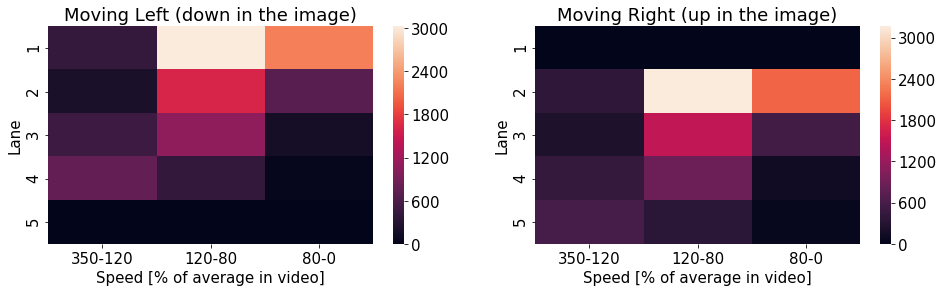

In [174]:
transitions_per_rel_speed(trans)

#### Effect of lane-transition on the moving vehicle

After an average lane-transition, the moving vehicle increases its speed by few km/h, in particular after moving left.

In [216]:
speeds = df.iloc[:,-11:-1]
trans_interval = np.array((trans.x1-20)/6,dtype=int)
trans['speed_before'] = [speeds[(df.video==v) & (df.car==c)].iloc[:,:i].values.mean()
                         for i,v,c in tqdm_notebook(zip(trans_interval,trans.video,trans.car),total=len(trans))]
trans['speed_during'] = [speeds[(df.video==v) & (df.car==c)].iloc[:,i].values.mean()
                         for i,v,c in tqdm_notebook(zip(trans_interval,trans.video,trans.car),total=len(trans))]
trans['speed_after'] = [speeds[(df.video==v) & (df.car==c)].iloc[:,i+1:].values.mean()
                         for i,v,c in tqdm_notebook(zip(trans_interval,trans.video,trans.car),total=len(trans))]

C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


In [232]:
trans['speed_before_rel'] = trans['speed_before'] - trans['speed_during']
trans['speed_after_rel'] = trans['speed_after'] - trans['speed_during']
trans['transition_sign'] = np.sign(trans.transition)
trans.sort_values(by=['transition_sign','lane_1'], inplace=True)

In [234]:
trans_agg = bp.agg_df(trans[(trans.speed_before.notna() & trans.speed_after.notna())],
                      ('speed_before_rel','speed_after_rel'), fac_name='When', val_name='Speed',
                      factors=('Before','After'))
trans_agg['Transition'] = [f"{l:.0f}->{l+1 if t>0 else l-1:.0f}" for l,t in zip(trans_agg.lane_1,trans_agg.transition)]
trans_agg['Speed\n[km/h wrt transition-moment]'] = 3.6 * trans_agg['Speed']

In [250]:
sg = 3.6*(trans.speed_after-trans.speed_before)
print('Speed gain [km/h]:')
print(f'mean={sg.mean():.1f}, median={sg.median():.1f}, sd={sg.std():.1f}')

tmp = trans[(trans.lane_1>=2) & (trans.transition>0)]
sg2 = 3.6*(tmp.speed_after-tmp.speed_before)
print('\nSpeed gain when moving left from the lefter lanes [km/h]:')
print(f'mean={sg2.mean():.1f}, median={sg2.median():.1f}, sd={sg2.std():.1f}')

Speed gain [km/h]:
mean=1.8, median=2.1, sd=5.8

Speed gain when moving left from the lefter lanes [km/h]:
mean=4.1, median=4.2, sd=5.8


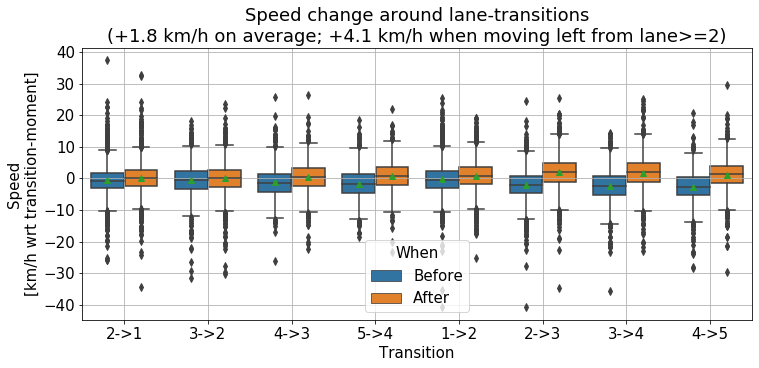

In [253]:
_, axs = plt.subplots(1,1, figsize=(12,5))

ax = axs
sns.boxplot(data=trans_agg, x='Transition', y='Speed\n[km/h wrt transition-moment]', hue='When', showmeans=True, ax=ax)
ax.set_title(f'Speed change around lane-transitions\n(+{sg.mean():.1f} km/h on average; +{sg2.mean():.1f} km/h when moving left from lane>=2)')
ax.grid()

In [ ]:
trans['Speed change after transition [km/h]'] = sg
trans['Transition'] = [f"{l:.0f}->{l+1 if t>0 else l-1:.0f}" for l,t in zip(trans.lane_1,trans.transition)]
dense_videos = vf.video[(detections_per_10m.values > 0.3)]
trans['Dense'] = trans.video.isin(dense_videos)

_, axs = plt.subplots(1,1, figsize=(12,5))

ax = axs
sns.boxplot(data=trans, x='Transition', y='Speed change after transition [km/h]', hue='Dense', showmeans=True, ax=ax)
ax.set_title(f'Speed change around lane-transitions | by traffic density')
ax.grid()

#### Externalities of lane-transitions

Note: the code below is **very inefficient**. Every df.loc[(df.video==v) & (df.car==c), :] should be replaced with naming df rows according to video & car, and accessing the rows accordingly. I didn't bother since I don't expect to run this another time.

In [284]:
trans['t1'] = [df.loc[(df.video==v) & (df.car==c), f't_{x1:d}'].values[0] for v,c,x1 in zip(trans.video,trans.car,trans.x1)]
trans['t2'] = [df.loc[(df.video==v) & (df.car==c), f't_{x2:d}'].values[0] for v,c,x1 in zip(trans.video,trans.car,trans.x2)]

In [287]:
trans['speed_before_lane1_5sec'] = [
    sf.loc[(sf.video==v[:-4]) & ((t0-5)<=sf.t) & (sf.t<=t0), f'v_x{x1:d}to{x2:d}_l{l:.0f}'].mean()
    for v, t0, x1, x2, l in tqdm_notebook(zip(trans.video, trans.t1, trans.x1, trans.x2, trans.lane_1), total=len(trans))
]

trans['speed_after_lane1_5sec'] = [
    sf.loc[(sf.video==v[:-4]) & (t0<=sf.t) & (sf.t<=t0+5), f'v_x{x1:d}to{x2:d}_l{l:.0f}'].mean()
    for v, t0, x1, x2, l in tqdm_notebook(zip(trans.video, trans.t2, trans.x1, trans.x2, trans.lane_1), total=len(trans))
]

trans['speed_before_lane2_5sec'] = [
    sf.loc[(sf.video==v[:-4]) & (t0-5<=sf.t) & (sf.t<=t0), f'v_x{x1:d}to{x2:d}_l{l:.0f}'].mean()
    for v, t0, x1, x2, l in tqdm_notebook(zip(trans.video, trans.t1, trans.x1, trans.x2, trans.lane_2), total=len(trans))
]

trans['speed_after_lane2_5sec'] = [
    sf.loc[(sf.video==v[:-4]) & (t0<=sf.t) & (sf.t<=t0+5), f'v_x{x1:d}to{x2:d}_l{l:.0f}'].mean()
    for v, t0, x1, x2, l in tqdm_notebook(zip(trans.video, trans.t2, trans.x1, trans.x2, trans.lane_2), total=len(trans))
]

In [295]:
trans['speed_change_lane1'] = 3.6 * (trans['speed_after_lane1_5sec'] - trans['speed_before_lane1_5sec'] )
trans['speed_change_lane2'] = 3.6 * (trans['speed_after_lane2_5sec'] - trans['speed_before_lane2_5sec'] )

trans_agg = bp.agg_df(trans[(trans.speed_change_lane1.notna() & trans.speed_change_lane2.notna())],
                      ('speed_change_lane1','speed_change_lane2'), fac_name='Lane', val_name='Speed change [km/h]',
                      factors=('Origin','Target'))
trans_agg['Transition'] = [f"{l:.0f}->{l+1 if t>0 else l-1:.0f}" for l,t in zip(trans_agg.lane_1,trans_agg.transition)]

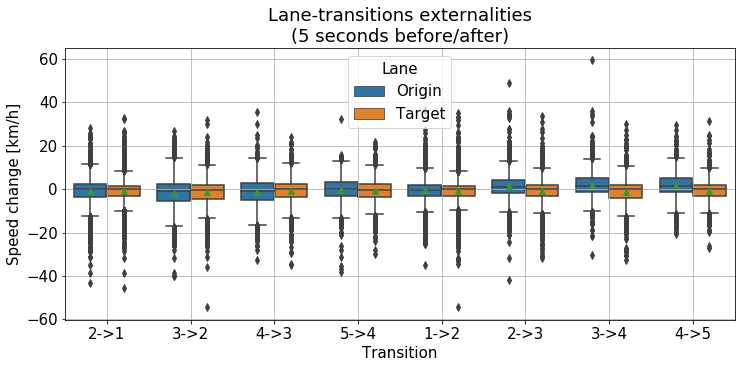

In [296]:
_, axs = plt.subplots(1,1, figsize=(12,5))

ax = axs
sns.boxplot(data=trans_agg, x='Transition', y='Speed change [km/h]', hue='Lane', showmeans=True, ax=ax)
ax.set_title(f'Lane-transitions externalities\n(5 seconds before/after)')
ax.grid()

Smoothed spatial data-frame:

In [326]:
sfr = sf.copy()
sfr.index = [f'{v:s}_{t*30/8:.0f}' for v,t in zip(sfr.video,sfr.t)]
for l in range(1,6):
    for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:]):
        sfr[f'v_x{x1:d}to{x2:d}_l{l:.0f}'] = \
         sfr[f'v_x{x1:d}to{x2:d}_l{l:.0f}'].rolling(12,min_periods=1,center=False).mean().values

Find externalities by horizon beyond the transition:

In [375]:
horizons = (-3,-2,-1,0,1,2,3,4,5,7,9,12,15,20,25)
hor0 = horizons[0]

In [386]:
trans_left = trans[trans.t1.notna() & trans.t2.notna() & (trans.lane_1>=2) & trans.transition>0]

In [387]:
for hor in horizons:
    trans_left[f'speed_lane2_{hor:.0f}s'] = 3.6 * np.array([
        sfr.loc[f'{v[:-4]:s}_{(t0+hor)*30/8:.0f}', f'v_x{x1:d}to{x2:d}_l{l:.0f}'] \
         if f'{v[:-4]:s}_{(t0+hor)*30/8:.0f}' in sfr.index else np.nan
        for v, t0, x1, x2, l in zip(trans_left.video, trans_left.t2, trans_left.x1, trans_left.x2, trans_left.lane_2)
    ])

C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [388]:
all_hors_available = trans_left.iloc[:,-len(horizons):].notna().all(axis=1)
trans_left = trans_left[all_hors_available]

In [389]:
trans_left

,video,car,x1,x2,lane_1,lane_2,transition,speed_before,speed_during,speed_after,...,speed_lane2_2s,speed_lane2_3s,speed_lane2_4s,speed_lane2_5s,speed_lane2_7s,speed_lane2_9s,speed_lane2_12s,speed_lane2_15s,speed_lane2_20s,speed_lane2_25s
165,20190520_112342.mp4,28,26,32,2.0,1.0,-1.0,14.989926,14.470209,13.470415,...,39.654661,41.216709,40.013537,40.042058,39.933923,49.528940,49.947051,42.632539,45.398840,71.568464
167,20190520_112342.mp4,28,38,44,2.0,1.0,-1.0,14.176596,12.492227,13.700239,...,42.035322,46.755508,44.566463,41.767324,39.235686,43.447420,50.387814,55.779737,45.113399,69.920688
217,20190520_112342.mp4,82,56,62,2.0,1.0,-1.0,15.273439,15.774919,15.982521,...,38.093961,48.994205,48.994205,48.994205,66.157182,69.971102,66.798371,57.014216,55.866606,52.688747
634,20190520_112342.mp4,998,68,74,2.0,1.0,-1.0,10.432550,11.094883,10.906614,...,50.533165,46.423983,45.968730,44.602971,42.005780,49.634745,38.805469,46.801622,51.694821,53.495710
661,20190520_112342.mp4,1221,38,44,2.0,1.0,-1.0,11.909089,12.255690,13.040752,...,49.746371,48.398278,44.353998,46.724913,48.549909,47.280662,47.907232,45.378040,41.070631,41.391471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20314,20190625_180254.mp4,1290,62,68,4.0,5.0,1.0,12.744991,13.083117,12.764672,...,48.557406,48.289948,48.289948,50.763100,50.763100,45.095874,46.876542,50.371202,48.908122,56.597009
20688,20190702_170703_slipping_protest.1.mp4,744,20,26,4.0,5.0,1.0,NaN,13.457832,15.258920,...,55.269968,55.447867,60.431468,60.431468,60.682895,59.881226,58.566008,53.893557,48.191185,46.914585
20702,20190702_170703_slipping_protest.1.mp4,800,44,50,4.0,5.0,1.0,13.583797,14.548236,15.081112,...,48.742012,51.597093,53.024633,56.670308,50.913261,48.353212,49.219854,56.825509,63.185641,59.985239
20907,20190703_160307_protest.2.mp4,2134,50,56,4.0,5.0,1.0,5.181566,4.253847,3.208391,...,25.965959,25.965959,24.962001,23.288738,21.950128,14.026723,10.300306,10.300306,5.895795,15.072533


In [390]:
for hor in horizons:
    trans_left[f'speed_lane2_{hor:.0f}s_rel'] = trans_left[f'speed_lane2_{hor:.0f}s'] - trans_left[f'speed_lane2_{hor0:.0f}s']

C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [391]:
trans_agg = bp.agg_df(trans_left,
                      [f'speed_lane2_{hor:.0f}s_rel' for hor in horizons],
                       fac_name='Horizon [s]', val_name='Speed [km/h]',
                       factors=[hor for hor in horizons]
                     )

#### The externalities of lane-transitions (to the left) on the target-lane

I would expect some immediate drop in the speed (*immediate* is hard to check since all spatial speeds are measured over intervals of time and road...), and then gradual return to the original speed (which intuitively takes no longer than 10-30 seconds).

According to the results, it is suspected that lane-transition is indeed followed by slower traffic in the target lane.
However, the significance of these findings is unclear, and in general it seems that the **externalities measured below are too noisy** to clearly notice any significant trends. This may be caused by several reasons:
- Inherent noise: the speeds measured in different horizons are necessarily of different vehicles.
- Limited resolution when measuring speed at certain time and certain location.
- FD: 50% of the detected lane-transitions are estimated to be false-detections.
- Estimated bias in the FD: externalities should be stronger in dense traffic; on the other hand, detections are harder (and false-detections are more likely) in such dense traffic.

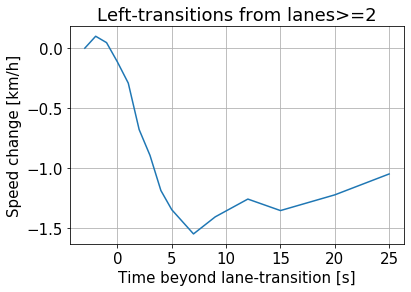

In [396]:
plt.plot(horizons, trans_agg.groupby('Horizon [s]')['Speed [km/h]'].apply(np.mean))
plt.xlabel('Time beyond lane-transition [s]')
plt.ylabel('Speed change [km/h]')
plt.title('Left-transitions from lanes>=2')
plt.grid()

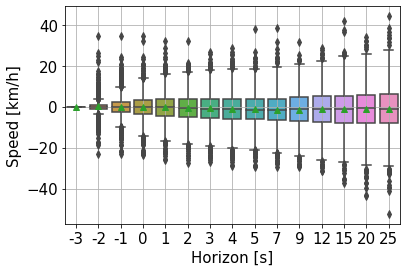

In [394]:
sns.boxplot(data=trans_agg, x='Horizon [s]', y='Speed [km/h]', showmeans=True)
plt.grid()

## Predicting models

#### Lane speed prediction within congestion
Within a congestion, one often looks for faster lanes to move to.
One may ask whether the currently fastest lane is expected to be accordingly fastest also down the road.
- Data preparation and limitations:
    - Unfortunately, the data effectively records speeds only in a road interval of around 60 meters, which is quite short for such sort of questions.
    - Since free-drive should not be relevant, only videos with density of at least 0.3 vehicles/10m (about half the videos) were considered.
    - Only 3K out of the remaining 74K videos-frames have available recorded speeds in all the lanes (up to few frames before/after).
- For each lane, its future speed was predicted as follows:
    - **Output** (5 outputs) - speed change within lane: `speed(lane l, end of frame, t+dt) - speed(lane l, beginning of frame, t)` (where `dt` is the average time required to cross the frame).
    - **Input** (4 per output) - relative speed in other lanes: `speed(lane l', beginning of frame, t) - speed(lane l, beginning of frame, t)`.
- Note that the model is **memoryless**, and in particular does not include:
    - Earlier speeds of the same vehicles - which are unavailable in the data since they "happened" earlier in the road.
    - Earlier speeds in the same location - since earlier the drivers were behind, and couldn't know these speeds.
- Results:
    - The linear models **explain 18% (out-of-sample) of the speed changes** along the 50 meters.
    - Regularization (ridge/lasso) does not seem helpful.
    - **Most of the speed-difference between adjacent lanes under congestion diminishes within 50 meters**: the optimal betas express correction of ~30% towards the neighbors-speeds, and since it occurs on both neighbors - most of the speed-difference diminishes.

#### TODO
- ARIMA model for traffic speed/density over time within videos (possibly with separation between lanes)

#### Prepare data

In [598]:
# Input:   speeds at location x=20 at lanes 1-5.
# Output:  speeds at location x=68 (x=74 is sometimes a bit noisier) at lanes 1-5, 13 frames later.
X = 3.6*sf[[f'v_x20to26_l{l:d}' for l in range(1,6)]].rolling(8,min_periods=1).mean()
Y = 3.6*sf[[f'v_x68to74_l{l:d}' for l in range(1,6)]].rolling(8,min_periods=1).mean()
print('Total frames', X.shape)

# Only consider videos with some congestion
videos = vf.video[(detections_per_10m.values > 0.3)]
ids = sf.video.isin([v[:-4] for v in videos])
X = X.loc[ids,:]
Y = Y.loc[ids,:]
print('With congestion', X.shape)

# Create offset between X & Y
# The offset of 13 frames comes from a 0-order approximation of ~50km/h for the traffic speed.
delta_frames = round(((68-20)/(50/3.6)) * (30/8))
print('Frames offset:', delta_frames)
X = X.iloc[:-delta_frames, :]
Y = Y.iloc[delta_frames:,  :]
print('With X/Y offset', X.shape)

# Only use frames with full data availability
ids = X.notna().all(axis=1) & Y.notna().all(axis=1)
X = X[ids]
Y = Y[ids]
print('With available lanes data', X.shape)

Total frames (186746, 5)
With congestion (74287, 5)
Frames offset: 13
With X/Y offset (74274, 5)


C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\idogr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


With available lanes data (3174, 5)


#### Learn

In [640]:
def learn_model(X, Y, model, models, explained_variances, cv=3):
    explained_variances.append( cross_validate(model, X, Y, cv=cv, scoring='explained_variance')['test_score'].mean() )
    model.fit(X, Y)
    models.append(model)

def learn_linear_models(X, Y, ridge_alpha=100, lasso_alpha=1, cv=3):
    models, explained_variances = [], []
    learn_model(X, Y, linear_model.LinearRegression(),       models, explained_variances, cv=cv)
    learn_model(X, Y, linear_model.Ridge(alpha=ridge_alpha), models, explained_variances, cv=cv)
    learn_model(X, Y, linear_model.Lasso(alpha=lasso_alpha), models, explained_variances, cv=cv)
    return models, explained_variances

In [670]:
coefs = np.zeros((5,5,3))
ve = np.zeros((5,3))

for l in range(1,3):
    # copy data
    X2 = X.copy()
    Y2 = Y.copy().iloc[:,l-1]
    # normalize data according to input lane
    Y2 = Y2 - X.iloc[:,l-1].values
    for i in range(5):
        X2.iloc[:,i] = X2.iloc[:,i] - X.iloc[:,l-1].values
    # learn
    models, ves = learn_linear_models(X2, Y2, 300, 0.5, 3)
    # save coefs
    for i in range(3):
        coefs[l-1,:,i] = models[i].coef_
        ve[l-1,i] = ves[i]

#### Display

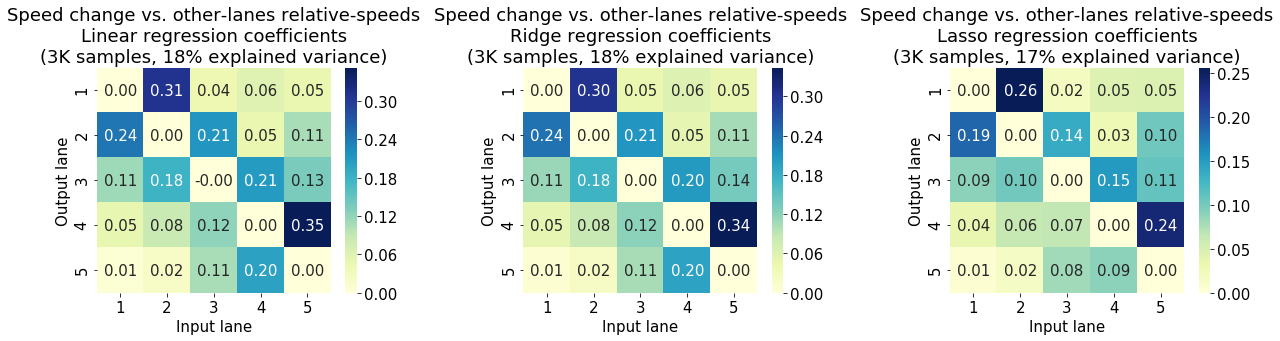

In [654]:
_, axs = plt.subplots(1,3, figsize=(18,5))

ax = axs[0]
sns.heatmap(coefs[:,:,0], xticklabels=range(1,6), yticklabels=range(1,6), ax=ax, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Input lane')
ax.set_ylabel('Output lane')
ax.set_title(f'Speed change vs. other-lanes relative-speeds\nLinear regression coefficients\n({len(X)//1000:d}K samples, {100*ve[:,0].mean():.0f}% explained variance)')

ax = axs[1]
sns.heatmap(coefs[:,:,1], xticklabels=range(1,6), yticklabels=range(1,6), ax=ax, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Input lane')
ax.set_ylabel('Output lane')
ax.set_title(f'Speed change vs. other-lanes relative-speeds\nRidge regression coefficients\n({len(X)//1000:d}K samples, {100*ve[:,1].mean():.0f}% explained variance)')

ax = axs[2]
sns.heatmap(coefs[:,:,2], xticklabels=range(1,6), yticklabels=range(1,6), ax=ax, cmap="YlGnBu", annot=True, fmt='.2f')
ax.set_xlabel('Input lane')
ax.set_ylabel('Output lane')
ax.set_title(f'Speed change vs. other-lanes relative-speeds\nLasso regression coefficients\n({len(X)//1000:d}K samples, {100*ve[:,2].mean():.0f}% explained variance)')

plt.tight_layout()

## Extreme events

#### Fastest & slowest vehicles

3.917459684862539 142.58894229381357


,car,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
19328,26,1,20190525_194340.mp4,6.013333,20190525,19.727778,7,265,True,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9370,985,1,20190520_232200.mp4,12.577778,20190520,23.366667,2,8,True,True,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN


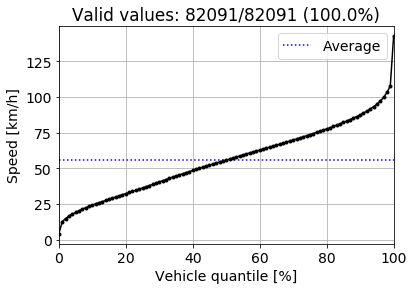

In [119]:
t.qplot(3.6*df.v, xlab='Vehicle', ylab='Speed [km/h]')
slowest = df.loc[df.v.idxmin(),'car']
fastest = df.loc[df.v.idxmax(),'car']
print(3.6*df.v.min(), 3.6*df.v.max())
df.iloc[[df.v.idxmin(), df.v.idxmax()], :]

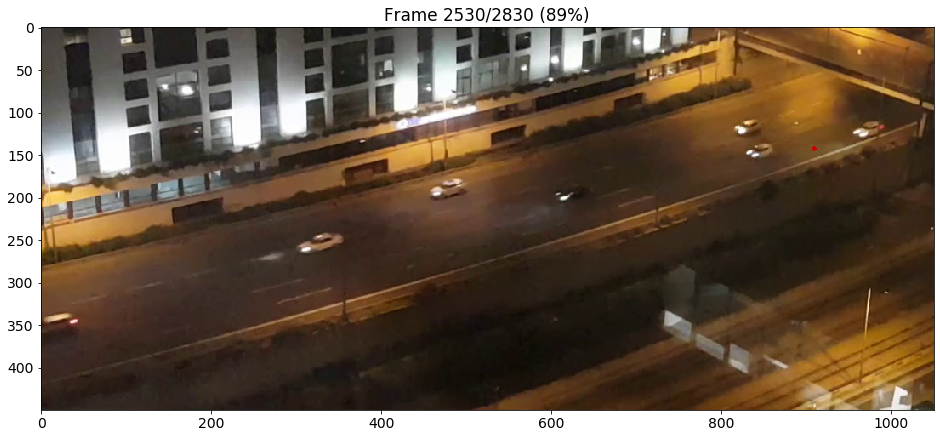

In [310]:
bp.show_car('20190520_232200', 985, display=1, dots=False, self_track=1, extra_frames=2, save_video='fastest_car_11pm_143kmh')

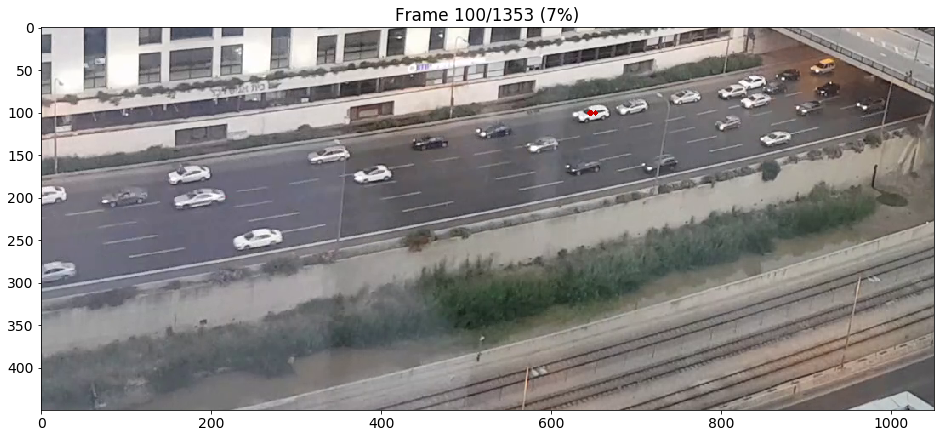

In [336]:
# slowest
# consider saving video with skipped frames or larger frame rate
bp.show_car('20190525_194340', 26, display=1, dots=False, self_track=1, goal_frame=100,
            save_video='../Analysis/slowest_car_1943pm_3.9kmh', save_frame='../Analysis/slowest_car_1943pm_3.9kmh')

#### Most & least dense frames

In [316]:
videos = bp.get_all_videos()
dense = (None, None, 0)
sparse = (None, None, np.inf)
for video in videos:
    with open(bp.DATA_DIR/f'{video:s}.pkl', 'rb') as f:
        N = pkl.load(f)['N']
        if N.max() > dense[2]:
            dense = (video, N.argmax(), N.max())
        if N.min() < sparse[2]:
            sparse = (video, N.argmin(), N.min())
sparse, dense

(('20190520_232200', 22, 0.0), ('20190612_175832', 105, 54.0))

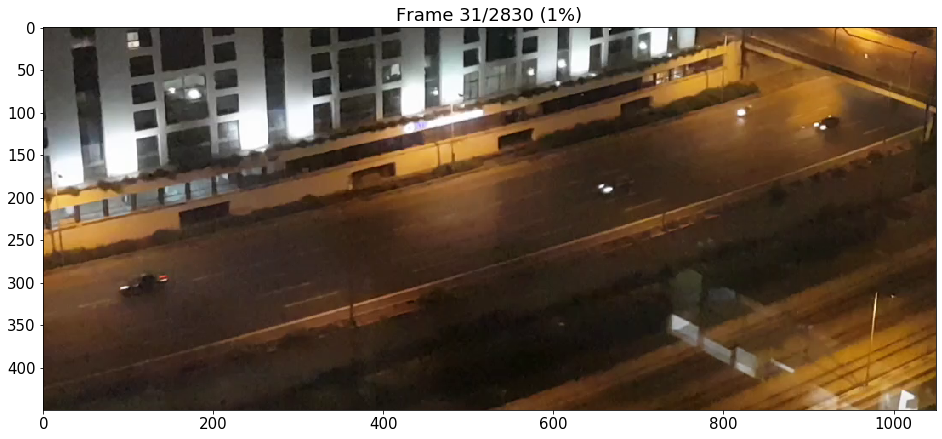

In [7]:
# Sparse
bp.show_car('20190520_232200', 9, display=2, self_track=0, goal_frame=28, extra_frames=-8, dots=False,
            save_video='../Analysis/Sparse_road_11pm', save_frame='../Analysis/Sparse_road_11pm')

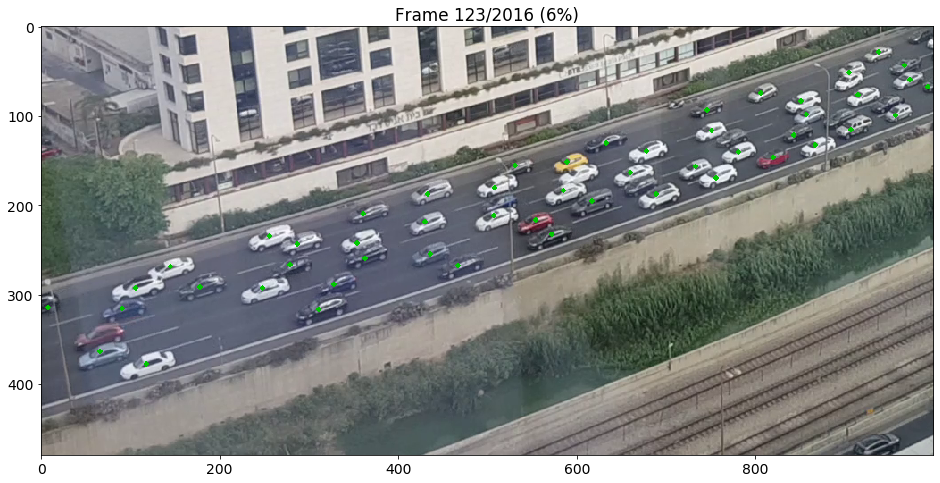

In [330]:
# Dense
bp.show_car('20190612_175832', 190, display=1, self_track=0, dots=0, all_detections=True,
            save_frame='../Analysis/Dense_road_6pm')

#### Looking for accidents

Note that since the most dense frames in the data don't contain car-accidents, then probably there are no directly-observed accidents in the data.
Since possible accidents can't be just overlooked, anomalies in relative speeds within videos were also studied.
However, the only interesting phenomenon observed was a time-window in a single video in which the **leftmost lane was significantly slower than the others**. While this can be explained by a disturbance later in the road, **no disturbance was directly observed**.

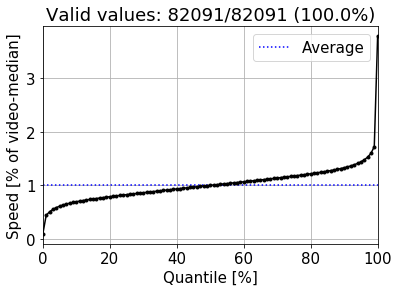

In [419]:
med_speeds = df.groupby('video')['v'].apply(lambda x: np.quantile(x,0.5))
df['video_q_v'] = [med_speeds[v] for v in df.video]
df['v_rel'] = df['v'] / df['video_q_v']
t.qplot(df['v_rel'], ylab='Speed [% of video-median]')

In [414]:
relatively_slow_cars = (df.v_rel<0.25) & (df.lane_50>2)
relatively_slow_cars = [(v,c) for v,c in zip(df.loc[relatively_slow_cars,'video'],df.loc[relatively_slow_cars,'car'],)]
print('Number of relatively-slow cars:', len(relatively_slow_cars))
print('A sample of cars:', relatively_slow_cars[:3])
print('Videos:', Counter([vc[0] for vc in relatively_slow_cars]))

Number of relatively-slow cars: 7
A sample of cars: [('20190529_091346.mp4', 2518), ('20190529_091346.mp4', 2525), ('20190529_091346.mp4', 2530)]
Videos: Counter({'20190529_091346.mp4': 7})


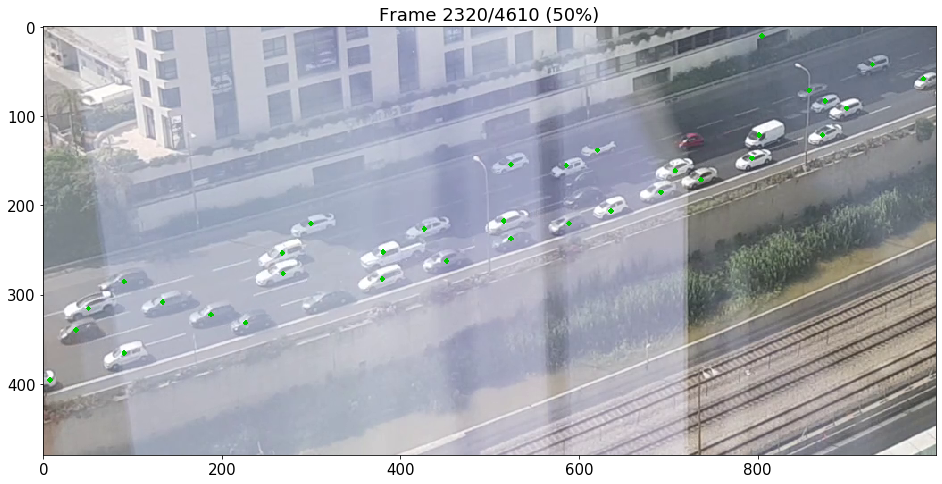

In [427]:
bp.show_car('20190529_091346', 2518, display=1, self_track=0, dots=0, all_detections=True, goal_frame=2320,
            save_frame='../Analysis/Left_lane_congestion_9am')